In [1]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize W&B API
api = wandb.Api()

# Replace with your entity and project name
ENTITY = 'juliannapiskorz' # e.g., 'username' or 'organization'
PROJECT = 'AFA4CATE_FIXED' # e.g., 'experiment_project'

# Fetch all runs in the project
runs = api.runs(f"{ENTITY}/{PROJECT}")

# Initialize a list to store run data
data = []

i=0
for run in runs:
    if (run.config["experiment_name"] not in  ["stop_acquisition_ihdp_new_appendix"]
        or run.config['acquisition_metric'] not in ["r_PO", "r_TE", "random", "r_sTE"]
        or run.config['threshold_variable'] != "TE"):
        continue
    i += 1
    # Extract summary metrics
    summary = run.summary
    
    # Extract config parameters if needed
    config = run.config
    
    # Ensure the required fields are present
    required_fields = ["total_score",
                       "total_cost", "number_predict", "number_withhold",
                       "average_cost_for_withhold",
                       "average_cost_for_predict",
                       "pehe_for_predict",
                       "pehe_for_withhold",
                       "total_score_per_cost"]
    if not all(field in summary for field in required_fields):
        continue  # Skip runs that don't have all required fields
    
    percentile_var_threshold = config["percentile_var_threshold"]
    total_score = summary["total_score"]
    total_cost = summary["total_cost"]
    number_predict = summary["number_predict"]
    number_withhold = summary["number_withhold"]
    average_cost_for_withhold = summary["average_cost_for_withhold"]
    average_cost_for_predict = summary["average_cost_for_predict"]
    pehe_for_predict = summary["pehe_for_predict"]
    pehe_for_withhold = summary["pehe_for_withhold"]
    total_score_per_cost = summary["total_score_per_cost"]
    acquisition_metric = config["acquisition_metric"]
    seed = config["seed"]
    
    # Check if acquisition_metric has an alpha parameter
    # Assuming alpha is stored in config if applicable
    # alpha = config.get("alpha", None)

    # if alpha is not None and acquisition_metric in ["r_TE_plus_var_unnorm"]:
    #     if alpha not in [1.0, 4.0]:
    #         continue
    #     # Create a unique metric name including alpha
    #     acquisition_metric = f"{acquisition_metric}_alpha_{alpha}"
    
    # Append the data
    data.append({
        "percentile_var_threshold": percentile_var_threshold,
        "total_score": total_score,
        "total_cost": total_cost,
        "number_predict": number_predict,
        "number_withhold": number_withhold,
        "average_cost_for_withhold": average_cost_for_withhold,
        "average_cost_for_predict": average_cost_for_predict,
        "pehe_for_predict": pehe_for_predict,
        "pehe_for_withhold": pehe_for_withhold,
        "total_score_per_cost": total_score_per_cost,
        "acquisition_metric": acquisition_metric,
        "seed": seed,
    })

# Create a DataFrame
df = pd.DataFrame(data)
print(i)

140


In [2]:
df.acquisition_metric.value_counts()

acquisition_metric
r_PO      35
r_TE      35
r_sTE     35
random    35
Name: count, dtype: int64

In [3]:
import numpy as np
df.replace("NaN", np.nan, inplace=True)

/tmp/ipykernel_2831738/3912243794.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("NaN", np.nan, inplace=True)


In [4]:
df.loc[df.isna().any(axis=1), 'pehe_for_withhold'] = 0
df.loc[df.isna().any(axis=1), 'average_cost_for_withhold'] = 0

In [5]:
df.isna().sum()

percentile_var_threshold     0
total_score                  0
total_cost                   0
number_predict               0
number_withhold              0
average_cost_for_withhold    0
average_cost_for_predict     0
pehe_for_predict             0
pehe_for_withhold            0
total_score_per_cost         0
acquisition_metric           0
seed                         0
dtype: int64

In [6]:
df_clean = df.dropna()

In [7]:
df_clean.head()

,percentile_var_threshold,total_score,total_cost,number_predict,number_withhold,average_cost_for_withhold,average_cost_for_predict,pehe_for_predict,pehe_for_withhold,total_score_per_cost,acquisition_metric,seed
0,0.7,18,187,18,12,7.083333,5.666667,0.104059,1.162969,0.096257,r_PO,1
1,0.7,26,257,26,4,4.750000,9.153846,0.217520,0.367979,0.101167,r_PO,4
2,0.7,19,197,19,11,6.818182,6.421053,0.125972,1.234358,0.096447,r_TE,1
3,0.7,24,292,26,4,5.250000,10.423077,0.227549,0.362013,0.082192,r_TE,4
4,0.7,19,295,19,11,8.181818,10.789474,0.111523,1.130757,0.064407,r_sTE,1


In [8]:
df_clean['average_score'] = df_clean['total_score'] / 30
df_clean['average_score_per_cost'] = df_clean['total_score_per_cost'] / 30

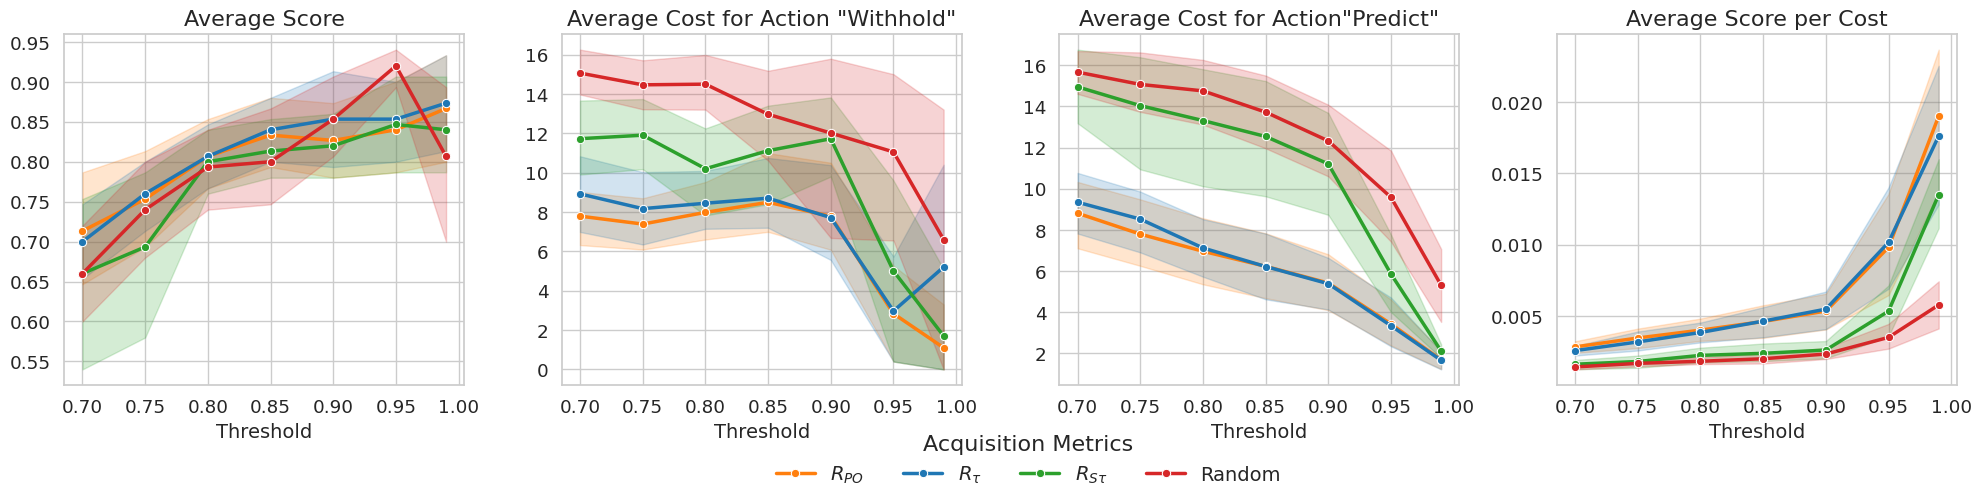

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_plot = df_clean.copy()
# Assuming df_clean is your cleaned DataFrame
# and aggregated_df is already defined as per your provided code

# Define the metrics to plot and their labels
plot_metrics = [
    ('average_score', 'Average Score'),
    ('average_cost_for_withhold', 'Average Cost for Action "Withhold"'),
    ('average_cost_for_predict', 'Average Cost for Action"Predict"'),
    ('average_score_per_cost', 'Average Score per Cost')
]
nice_names = {"r_TE": r"$R_\tau$", "r_PO": r"$R_{PO}$", "r_sTE": r"$R_{S\tau}$", "random": "Random", "neg_r_TE_plus_var": r"$R_{\tau\delta}$"}
df_plot['metric_label'] = df_plot['acquisition_metric'].map(nice_names)

sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# Define a color palette based on the number of unique acquisition metrics
palette = sns.color_palette("tab10", n_colors=df_plot['acquisition_metric'].nunique())
palette_dict = {r"$R_\tau$": palette[0], r"$R_{PO}$": palette[1], r"$R_{S\tau}$": palette[2], "Random": palette[3]}

# Create a color mapping dictionary
color_mapping = dict(zip(df_plot['metric_label'].unique(), palette))

# Initialize the figure with 4 subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

for ax, (metric, label) in zip(axes, plot_metrics):
    # Plot the average metric line
    sns.lineplot(
        data=df_plot,
        x="percentile_var_threshold",
        y=metric,
        hue="metric_label",
        marker="o",
        errorbar=('ci', 90),
        ax=ax,
        palette=palette_dict,
        linewidth=2.5
    )

    # Set subplot title and labels
    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Threshold", fontsize=14)
    ax.set_ylabel("", fontsize=12)

# Adjust layout to accommodate the legend and titles
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Create the legend outside the grid
fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=len(labels),
    fontsize=14,
    title='Acquisition Metrics',
    title_fontsize=16,
    frameon=False,
    bbox_to_anchor=(0.52, -0.08)  # Adjust y-coordinate based on your layout
)

# Remove individual legends from subplots
for ax in axes:
    ax.get_legend().remove()

# Set an overall title for the figure
# fig.suptitle("Metrics vs Percentile Var Threshold by Acquisition Metric", fontsize=16, y=0.98)

# Save the figure (optional)
plt.savefig(f"stop_acquisition_ihdp_new.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## Threshold variable: PO

In [1]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize W&B API
api = wandb.Api()

# Replace with your entity and project name
ENTITY = 'juliannapiskorz' # e.g., 'username' or 'organization'
PROJECT = 'AFA4CATE_FIXED' # e.g., 'experiment_project'

# Fetch all runs in the project
runs = api.runs(f"{ENTITY}/{PROJECT}")

# Initialize a list to store run data
data = []

i=0
for run in runs:
    if (run.config["experiment_name"] not in  ["stop_acquisition_ihdp_appendix_vars"]
        or run.config['acquisition_metric'] not in ["r_PO", "r_TE", "random", "r_sTE"]):
        continue
    i += 1
    # Extract summary metrics
    summary = run.summary
    
    # Extract config parameters if needed
    config = run.config
    
    # Ensure the required fields are present
    required_fields = ["total_score",
                       "total_cost", "number_predict", "number_withhold",
                       "average_cost_for_withhold",
                       "average_cost_for_predict",
                       "pehe_for_predict",
                       "pehe_for_withhold",
                       "total_score_per_cost"]
    if not all(field in summary for field in required_fields):
        continue  # Skip runs that don't have all required fields
    
    percentile_var_threshold = config["percentile_var_threshold"]
    total_score = summary["total_score"]
    total_cost = summary["total_cost"]
    number_predict = summary["number_predict"]
    number_withhold = summary["number_withhold"]
    average_cost_for_withhold = summary["average_cost_for_withhold"]
    average_cost_for_predict = summary["average_cost_for_predict"]
    pehe_for_predict = summary["pehe_for_predict"]
    pehe_for_withhold = summary["pehe_for_withhold"]
    total_score_per_cost = summary["total_score_per_cost"]
    acquisition_metric = config["acquisition_metric"]
    seed = config["seed"]
    threshold_variable = config["threshold_variable"]
    
    # Check if acquisition_metric has an alpha parameter
    # Assuming alpha is stored in config if applicable
    # alpha = config.get("alpha", None)

    # if alpha is not None and acquisition_metric in ["r_TE_plus_var_unnorm"]:
    #     if alpha not in [1.0, 4.0]:
    #         continue
    #     # Create a unique metric name including alpha
    #     acquisition_metric = f"{acquisition_metric}_alpha_{alpha}"
    
    # Append the data
    data.append({
        "percentile_var_threshold": percentile_var_threshold,
        "total_score": total_score,
        "total_cost": total_cost,
        "number_predict": number_predict,
        "number_withhold": number_withhold,
        "average_cost_for_withhold": average_cost_for_withhold,
        "average_cost_for_predict": average_cost_for_predict,
        "pehe_for_predict": pehe_for_predict,
        "pehe_for_withhold": pehe_for_withhold,
        "total_score_per_cost": total_score_per_cost,
        "acquisition_metric": acquisition_metric,
        "seed": seed,
        "threshold_variable": threshold_variable,
    })

# Create a DataFrame
df = pd.DataFrame(data)
print(i)

280


In [2]:
df.acquisition_metric.value_counts()

acquisition_metric
r_PO      70
r_TE      70
r_sTE     70
random    70
Name: count, dtype: int64

In [3]:
import numpy as np
df.replace("NaN", np.nan, inplace=True)

/tmp/ipykernel_2903528/3912243794.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("NaN", np.nan, inplace=True)


In [4]:
df.loc[df.pehe_for_withhold.isna(), 'pehe_for_withhold'] = 0
df.loc[df.pehe_for_predict.isna(), 'pehe_for_predict'] = 0
df.loc[df.average_cost_for_withhold.isna(), 'average_cost_for_withhold'] = 0
df.loc[df.average_cost_for_predict.isna(), 'average_cost_for_predict'] = 0

In [5]:
df.loc[df.pehe_for_withhold.isna()]['number_predict']

Series([], Name: number_predict, dtype: int64)

In [6]:
df.isna().sum()

percentile_var_threshold     0
total_score                  0
total_cost                   0
number_predict               0
number_withhold              0
average_cost_for_withhold    0
average_cost_for_predict     0
pehe_for_predict             0
pehe_for_withhold            0
total_score_per_cost         0
acquisition_metric           0
seed                         0
threshold_variable           0
dtype: int64

In [7]:
df_clean = df.dropna()

In [8]:
df_clean.head()

,percentile_var_threshold,total_score,total_cost,number_predict,number_withhold,average_cost_for_withhold,average_cost_for_predict,pehe_for_predict,pehe_for_withhold,total_score_per_cost,acquisition_metric,seed,threshold_variable
0,0.7,0,59,0,30,1.966667,0.0,0.000000,0.680415,0.000000,r_PO,1,PO
1,0.7,2,113,2,28,3.178571,12.0,0.098982,0.274672,0.017699,r_PO,4,PO
2,0.7,0,517,0,30,17.233333,0.0,0.000000,0.378347,0.000000,r_PO,1,sTE
3,0.7,0,57,0,30,1.900000,0.0,0.000000,0.694479,0.000000,r_TE,1,PO
4,0.7,1,88,1,29,2.758621,8.0,0.107778,0.288839,0.011364,r_TE,4,PO


In [9]:
df_clean['average_score'] = df_clean['total_score'] / 30
df_clean['average_score_per_cost'] = df_clean['total_score_per_cost'] / 30

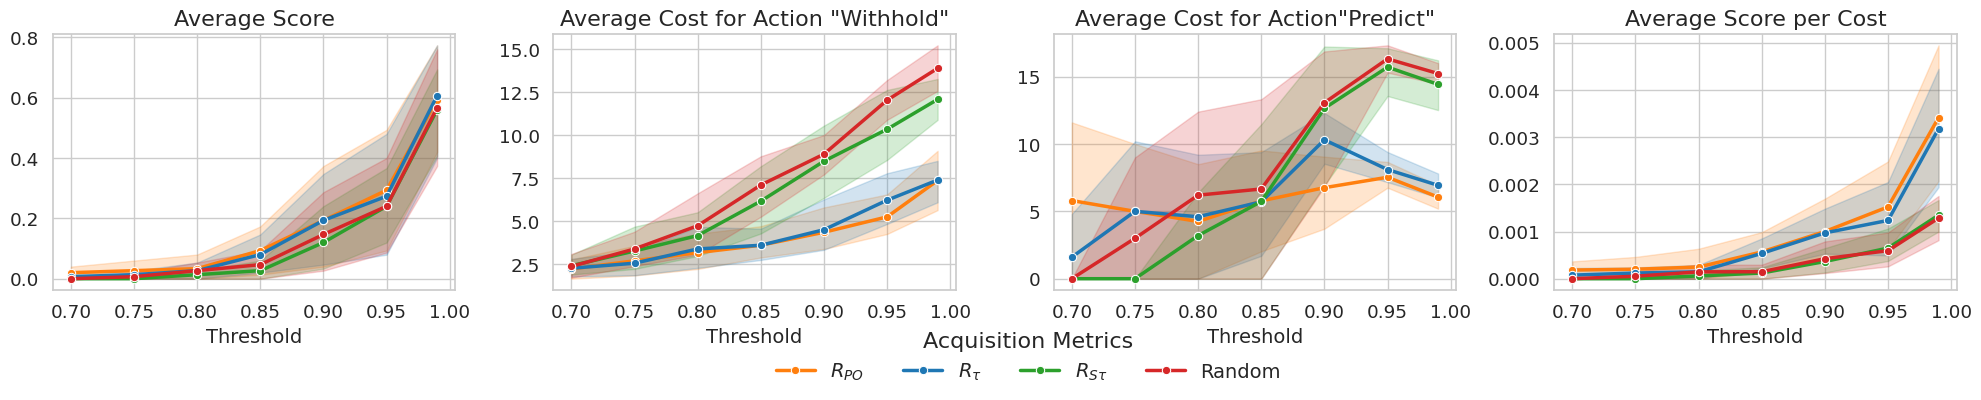

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

threshold_variable = 'PO'

df_plot = df_clean.copy()
df_plot = df_plot[df_plot['threshold_variable'] == threshold_variable]
# Assuming df_clean is your cleaned DataFrame
# and aggregated_df is already defined as per your provided code

# Define the metrics to plot and their labels
plot_metrics = [
    ('average_score', 'Average Score'),
    ('average_cost_for_withhold', 'Average Cost for Action "Withhold"'),
    ('average_cost_for_predict', 'Average Cost for Action"Predict"'),
    ('average_score_per_cost', 'Average Score per Cost')
]
nice_names = {"r_TE": r"$R_\tau$", "r_PO": r"$R_{PO}$", "r_sTE": r"$R_{S\tau}$", "random": "Random", "neg_r_TE_plus_var": r"$R_{\tau\delta}$"}
df_plot['metric_label'] = df_plot['acquisition_metric'].map(nice_names)

sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# Define a color palette based on the number of unique acquisition metrics
palette = sns.color_palette("tab10", n_colors=df_plot['acquisition_metric'].nunique())
palette_dict = {r"$R_\tau$": palette[0], r"$R_{PO}$": palette[1], r"$R_{S\tau}$": palette[2], "Random": palette[3]}

# Create a color mapping dictionary
color_mapping = dict(zip(df_plot['metric_label'].unique(), palette))

# Initialize the figure with 4 subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

for ax, (metric, label) in zip(axes, plot_metrics):
    # Plot the average metric line
    sns.lineplot(
        data=df_plot,
        x="percentile_var_threshold",
        y=metric,
        hue="metric_label",
        marker="o",
        errorbar=('ci', 90),
        ax=ax,
        palette=palette_dict,
        linewidth=2.5
    )

    # Set subplot title and labels
    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Threshold", fontsize=14)
    ax.set_ylabel("", fontsize=12)

# Adjust layout to accommodate the legend and titles
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Create the legend outside the grid
fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=len(labels),
    fontsize=14,
    title='Acquisition Metrics',
    title_fontsize=16,
    frameon=False,
    bbox_to_anchor=(0.52, -0.08)  # Adjust y-coordinate based on your layout
)

# Remove individual legends from subplots
for ax in axes:
    ax.get_legend().remove()

# Set an overall title for the figure
# fig.suptitle("Metrics vs Percentile Var Threshold by Acquisition Metric", fontsize=16, y=0.98)

# Save the figure (optional)
plt.savefig(f"stop_acquisition_old_ihdp_{threshold_variable}.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
